<a href="https://colab.research.google.com/github/KanakBarfa/RainfallPrdiction/blob/main/AusRain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Brief explaination of various regression models

## Dummy Model

The Dummy Model makes predictions using simple strategies like always predicting the majority class. It serves as a baseline for comparing the performance of more complex models.

## XGBoost

XGBoost is an ensemble learning algorithm that combines the predictions of multiple decision trees. It minimizes a cost function by adding decision trees, and each tree corrects the errors of the previous ones.

## Random Forest

Random Forest is an ensemble learning method that constructs multiple decision trees during training. It makes predictions by averaging or taking a majority vote from the individual trees.

## KNN (K-Nearest Neighbors)

KNN makes predictions based on the majority class or average value of the 'k' nearest data points in the feature space. The choice of 'k' influences the model's performance.

## Decision Tree

Decision Tree is a tree-like model that makes decisions based on the values of input features. It splits the data into subsets based on feature thresholds and assigns outcomes to leaf nodes.

## Gradient Boost

Gradient Boost builds a series of weak learners (often decision trees) sequentially. Each new learner corrects the errors of the combined model so far. It minimizes a loss function during training.

## Logistic Regression

Logistic Regression models the probability that an instance belongs to a particular class. It uses the logistic function to transform a linear combination of input features into a probability score.

# Importing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.model_selection import train_test_split , cross_val_score , RepeatedStratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import svm
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.dummy import DummyClassifier
from sklearn.metrics import roc_auc_score , classification_report , accuracy_score , confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
df=pd.read_csv('/content/drive/My Drive/assets/data.csv')
df=df.iloc[:,:23]
df = df.drop_duplicates()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


<ipython-input-71-8331a90ec73d>:20: DtypeWarning: Columns (24,25) have mixed types. Specify dtype option on import or set low_memory=False.
  df=pd.read_csv('/content/drive/My Drive/assets/data.csv')


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,01-12-2008,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,02-12-2008,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,03-12-2008,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,04-12-2008,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,05-12-2008,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


We are given-
1. Date
2. Location
3. Temprature
4. Wind Measurements
5. Sunshine
6. Humidity
7. Pressure
8. Cloud

We have to train our model such that given the data, will it rain?

First, lets apply EDA in the dataset

# EDA

In [ ]:
df.isna().sum()/len(df)

Date             0.000000
Location         0.000000
MinTemp          0.010209
MaxTemp          0.008669
Rainfall         0.022419
Evaporation      0.431665
Sunshine         0.480098
WindGustDir      0.070989
WindGustSpeed    0.070555
WindDir9am       0.072639
WindDir3pm       0.029066
WindSpeed9am     0.012148
WindSpeed3pm     0.021050
Humidity9am      0.018246
Humidity3pm      0.030984
Pressure9am      0.103568
Pressure3pm      0.103314
Cloud9am         0.384216
Cloud3pm         0.408071
Temp9am          0.012148
Temp3pm          0.024811
RainToday        0.022419
RainTomorrow     0.022460
dtype: float64

Since features with object data type have low missing values, dropping the data-entries that are missing

In [ ]:
df_objects_col=df.select_dtypes(include=['object'])
for col in df_objects_col.columns:
  df.dropna(subset=[col], inplace=True)
  df_objects_col.dropna(subset=[col],inplace=True)

Date won't be directly useful, and trend among date is much complicated than month, so dropping date column and add month

In [ ]:
df_objects_col['Date'] = pd.to_datetime(df_objects_col['Date'], format='%d-%m-%Y')
df_objects_col['Month'] = df_objects_col['Date'].dt.strftime('%B')
df_objects_col.drop('Date', axis=1, inplace=True)

Now, let's look at integer type data

In [ ]:
df_num = df.select_dtypes(include = ['float64', 'int64'])

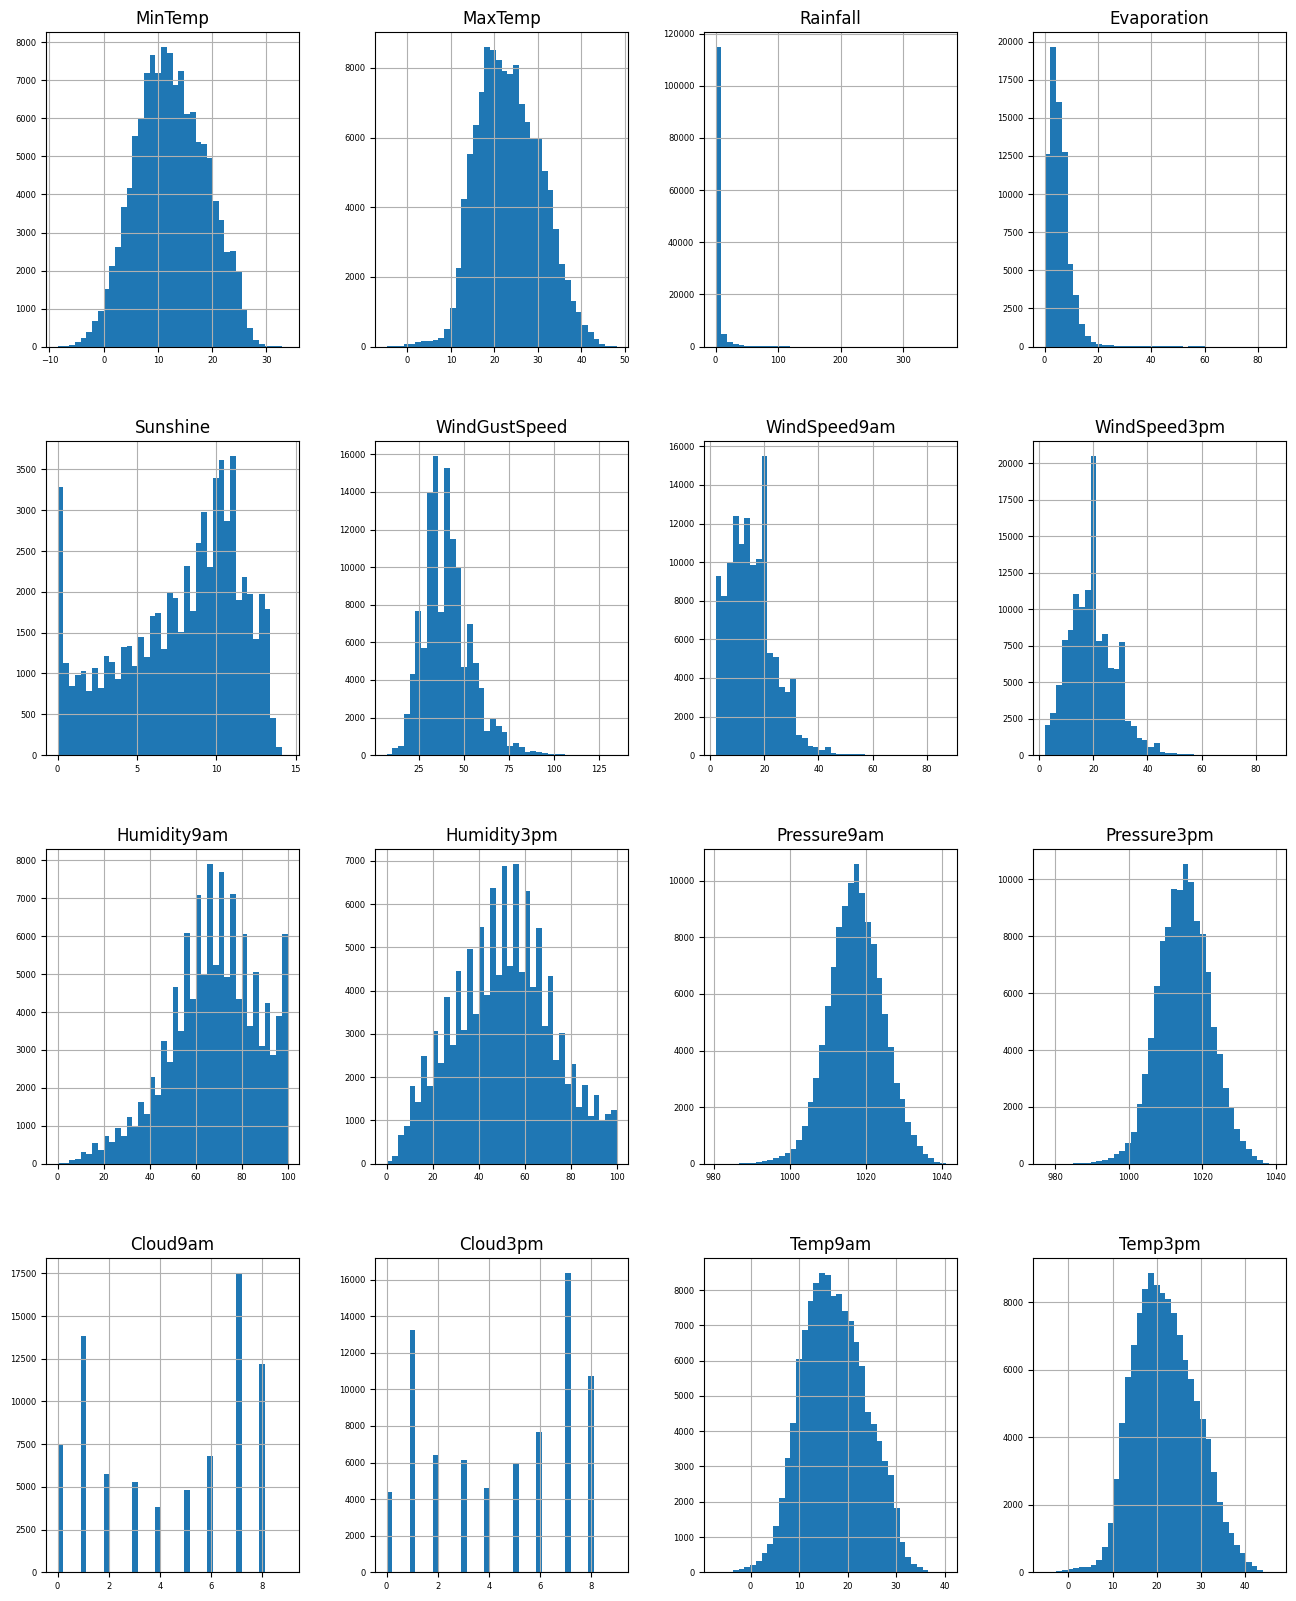

In [ ]:
df_num.hist(figsize=(16, 20), bins=40, xlabelsize=6, ylabelsize=6);

These graphs shows the trend in various features. Lets check boxplot for outliers

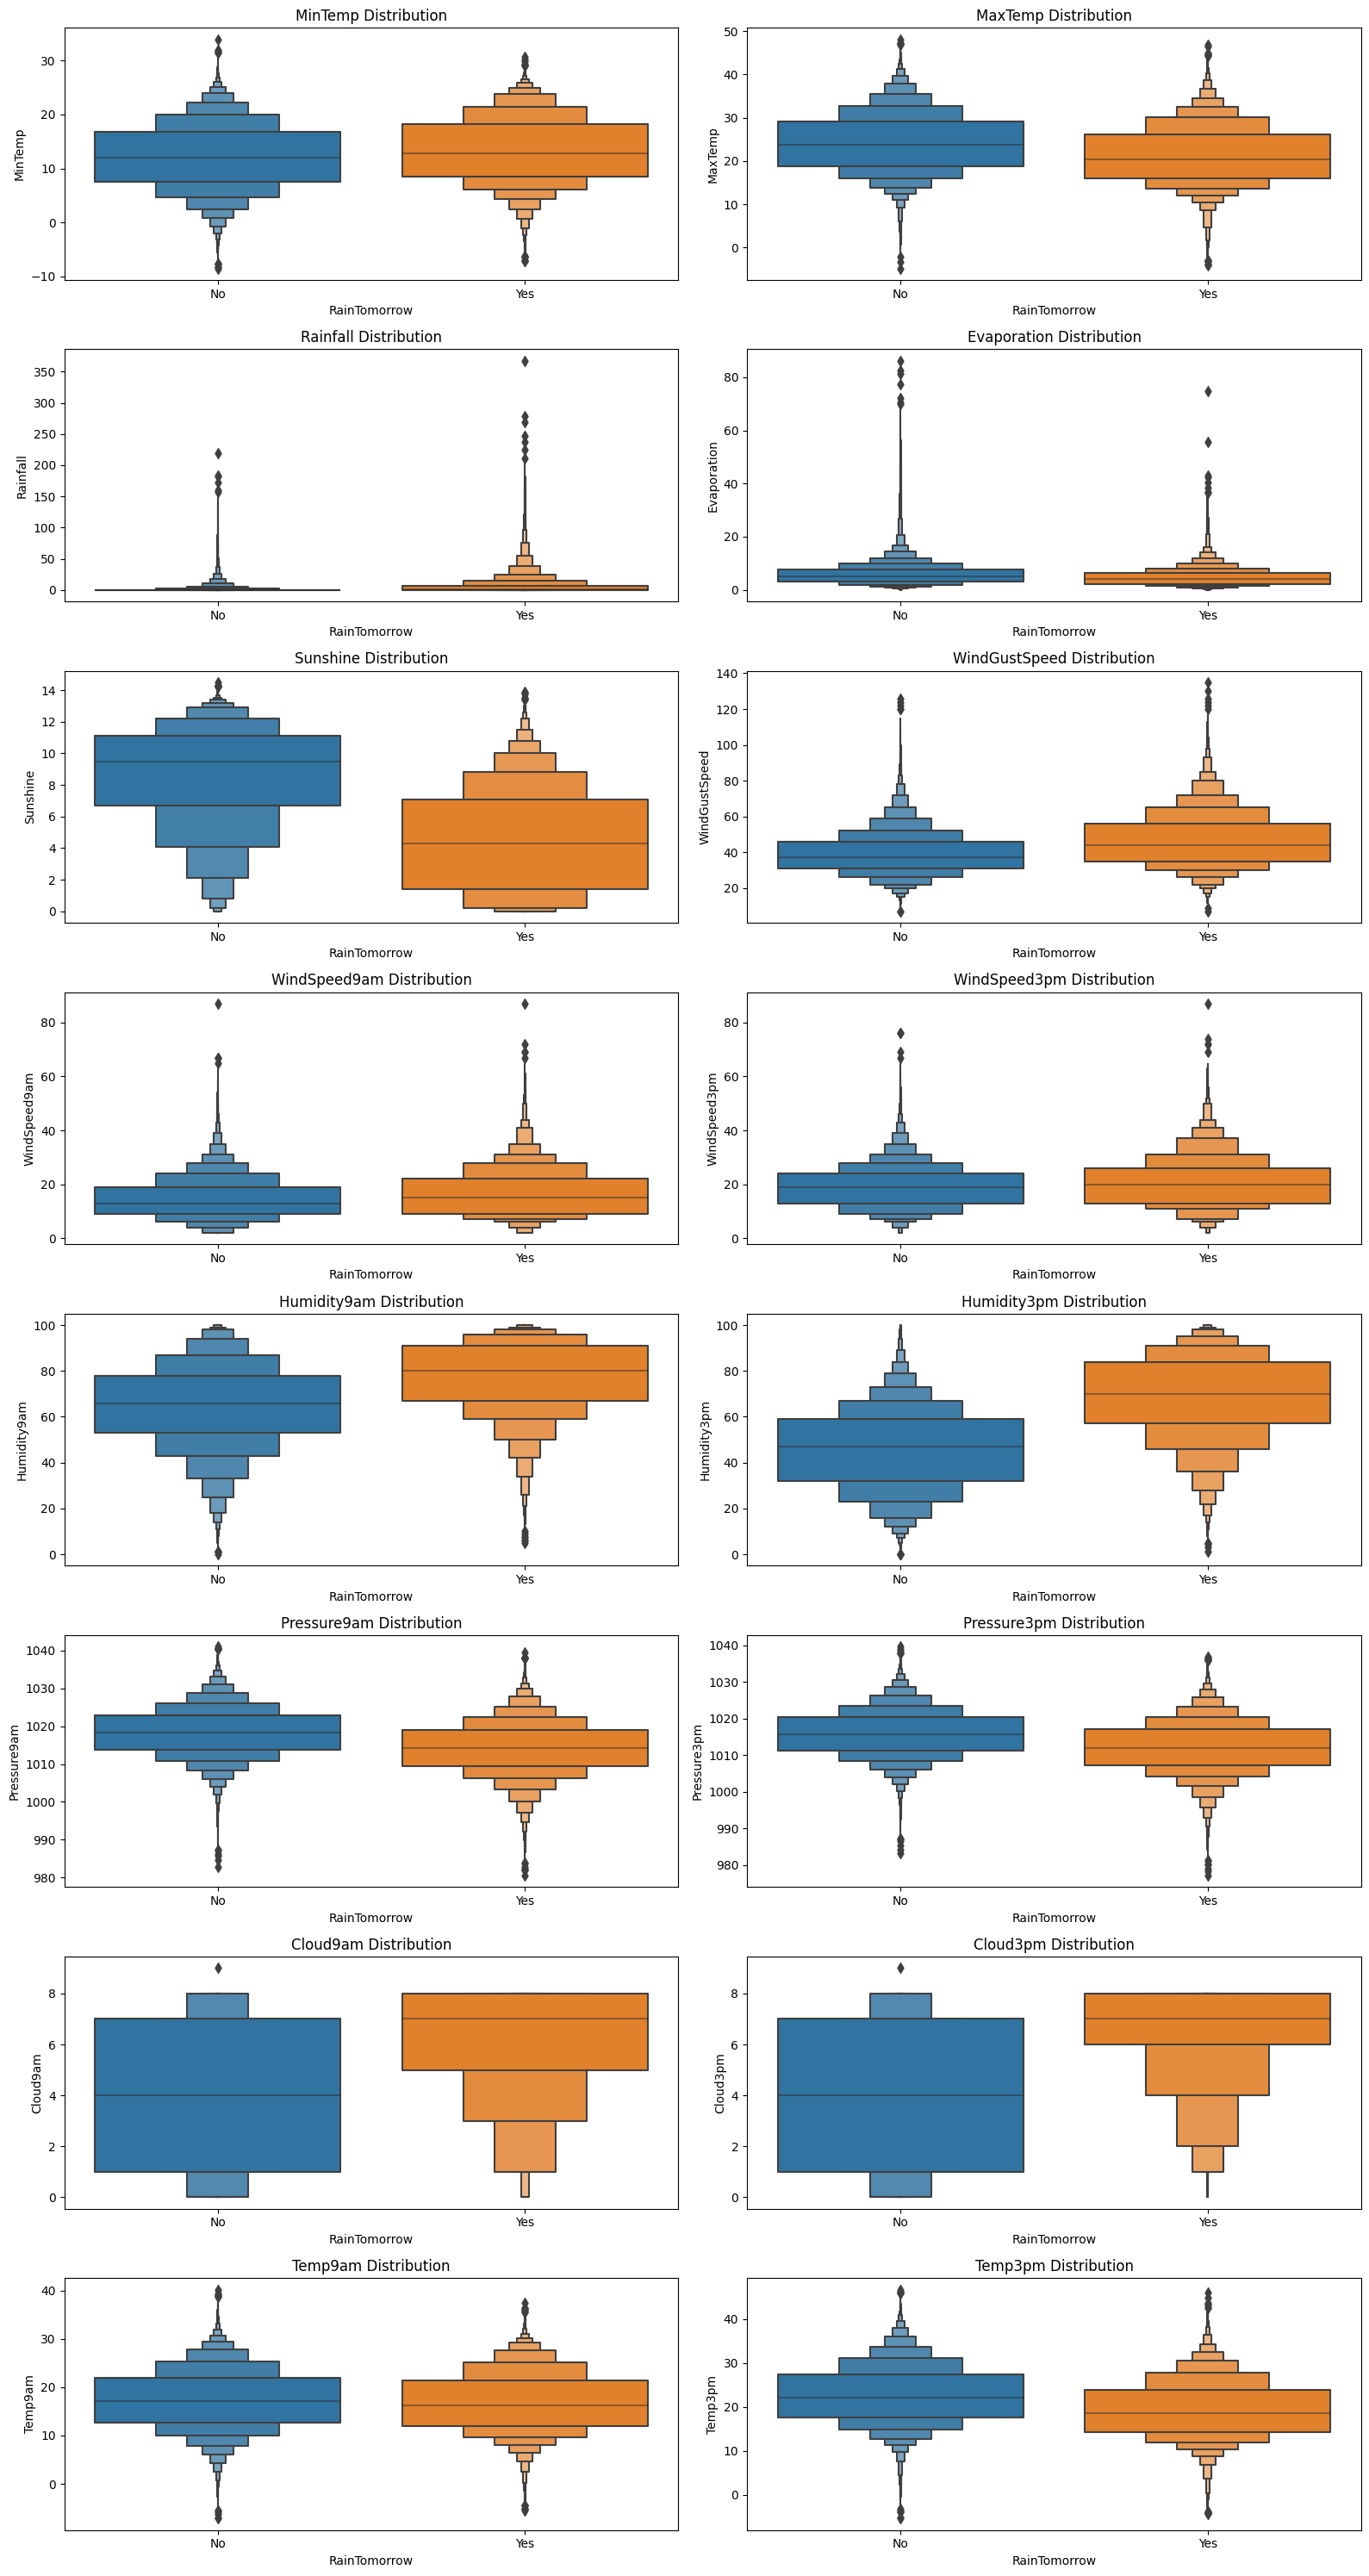

In [ ]:
fig, axes = plt.subplots(nrows=len(df_num.columns) // 2, ncols=2, figsize=(16, 30))

for idx, column in enumerate(df_num):
    row_idx = idx // 2
    col_idx = idx % 2

    sns.boxenplot( x='RainTomorrow' , y= column , data=df, ax=axes[row_idx, col_idx])

    axes[row_idx, col_idx].set_xlabel("RainTomorrow")
    axes[row_idx, col_idx].set_ylabel(column)
    axes[row_idx, col_idx].set_title(f"{column} Distribution")

plt.tight_layout()
plt.show()

### Setting outliers to a certain limit points

In [ ]:
def outlier_thresholds (dataframe, column, q1=0.25, q3=0.75) :
    quartile1 = dataframe[column].quantile(q1)
    quartile3 = dataframe[column].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

# Checking Outliers
def check_outlier(dataframe, column):
    low_limit, up_limit = outlier_thresholds(dataframe, column)
    outliers = (dataframe[column] > up_limit) | (dataframe[column] < low_limit)
    if outliers.any():
        return True
    else:
        return False

# Removing the outliers
def replace_with_thresholds (dataframe, column) :
    low_limit , up_limit = outlier_thresholds(dataframe, column)
    dataframe.loc[(dataframe[column] < low_limit), column] = low_limit
    dataframe.loc[(dataframe[column] > up_limit), column] = up_limit

In [ ]:
for column in (df_num.columns):
    replace_with_thresholds(df_num, column)

### Correlation heat map

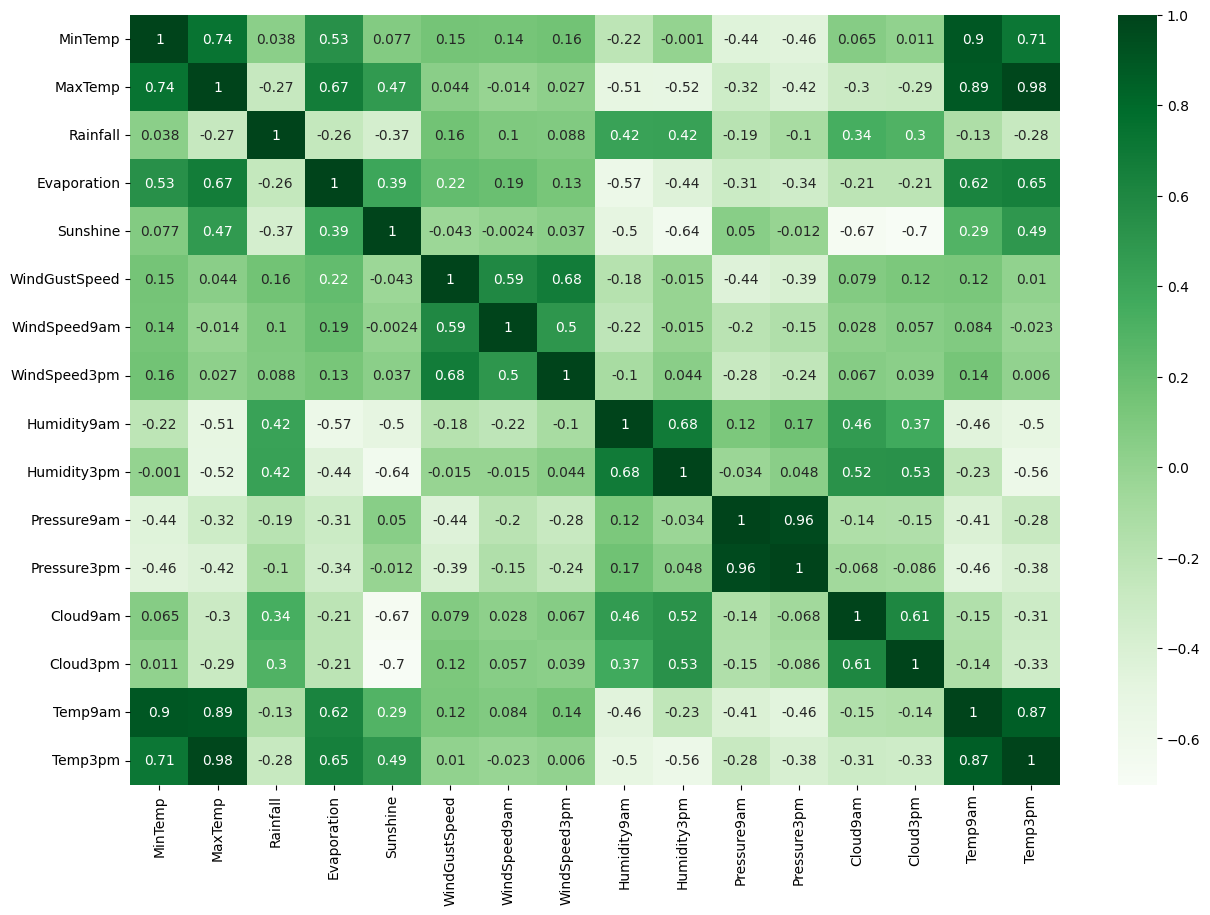

In [ ]:
corr = df_num.corr()
fig , ax = plt.subplots(figsize=(15 , 10))
sns.heatmap(corr ,annot= True , ax=ax , cmap= 'Greens');

Here, it can be seen that Temp 9am, Temp3pm, Min temp and Max temp are highly correlated. And so is Pressure at 9am and 3pm. So it is good to drop some of these columns

In [ ]:
df_num.drop(columns = ['MinTemp','Temp9am','Pressure9am','Temp3pm'], inplace = True)

In [ ]:
df=pd.concat([df_num,df_objects_col],axis=1)

### Imputing missing values

In [ ]:
df.isna().sum()/len(df)

MaxTemp          0.000364
Rainfall         0.000000
Evaporation      0.409401
Sunshine         0.457708
WindGustSpeed    0.000000
WindSpeed9am     0.000000
WindSpeed3pm     0.000000
Humidity9am      0.008180
Humidity3pm      0.012303
Pressure3pm      0.073309
Cloud9am         0.373729
Cloud3pm         0.389888
Location         0.000000
WindGustDir      0.000000
WindDir9am       0.000000
WindDir3pm       0.000000
RainToday        0.000000
RainTomorrow     0.000000
Month            0.000000
dtype: float64

We will use mean imputer for numerical data and mode imputer for object type data

In [ ]:
most_imputer = SimpleImputer(missing_values = np.nan, strategy = 'most_frequent')
mean_imputer = SimpleImputer(missing_values = np.nan, strategy = 'mean')

In [ ]:
#Object type data
df.WindGustDir = most_imputer.fit_transform(df[["WindGustDir"]])
df.WindDir9am = most_imputer.fit_transform(df[["WindDir9am"]])
df.WindDir3pm = most_imputer.fit_transform(df[["WindDir3pm"]])
df.RainToday = most_imputer.fit_transform(df[["RainToday"]])
df.RainTomorrow = most_imputer.fit_transform(df[["RainTomorrow"]])
#Numerical Data
df.MaxTemp = mean_imputer.fit_transform(df[["MaxTemp"]])
df.Rainfall = mean_imputer.fit_transform(df[["Rainfall"]])
df.WindGustSpeed = mean_imputer.fit_transform(df[["WindGustSpeed"]])
df.WindSpeed9am = mean_imputer.fit_transform(df[["WindSpeed9am"]])
df.WindSpeed3pm = mean_imputer.fit_transform(df[["WindSpeed3pm"]])
df.Humidity9am = mean_imputer.fit_transform(df[["Humidity9am"]])
df.Humidity3pm = mean_imputer.fit_transform(df[["Humidity3pm"]])
df.Pressure3pm = mean_imputer.fit_transform(df[["Pressure3pm"]])
df.Evaporation = mean_imputer.fit_transform(df[["Evaporation"]])
df.Sunshine = mean_imputer.fit_transform(df[["Sunshine"]])
df.Cloud9am = mean_imputer.fit_transform(df[["Cloud9am"]])
df.Cloud3pm = mean_imputer.fit_transform(df[["Cloud3pm"]])

In [ ]:
df.isnull().sum()/len(df)

MaxTemp          0.0
Rainfall         0.0
Evaporation      0.0
Sunshine         0.0
WindGustSpeed    0.0
WindSpeed9am     0.0
WindSpeed3pm     0.0
Humidity9am      0.0
Humidity3pm      0.0
Pressure3pm      0.0
Cloud9am         0.0
Cloud3pm         0.0
Location         0.0
WindGustDir      0.0
WindDir9am       0.0
WindDir3pm       0.0
RainToday        0.0
RainTomorrow     0.0
Month            0.0
dtype: float64

Now, we will use label encoder for object-type data

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = preprocessing.LabelEncoder()
df['Location']= label_encoder.fit_transform(df['Location'])
df['WindGustDir']= label_encoder.fit_transform(df['WindGustDir'])
df['WindDir9am']= label_encoder.fit_transform(df['WindDir9am'])
df['WindDir3pm']= label_encoder.fit_transform(df['WindDir3pm'])
df['RainToday']= label_encoder.fit_transform(df['RainToday'])
df['RainTomorrow']= label_encoder.fit_transform(df['RainTomorrow'])
df['Month']=label_encoder.fit_transform(df['Month'])

In [ ]:
df.head()

,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustSpeed,WindSpeed9am,WindSpeed3pm,Humidity9am,Humidity3pm,Pressure3pm,Cloud9am,Cloud3pm,Location,WindGustDir,WindDir9am,WindDir3pm,RainToday,RainTomorrow,Month
0,22.9,0.6,5.458105,7.718384,44.0,20.0,24.0,71.0,22.0,1007.1,8.000000,4.491408,1,13,13,14,0,0,2
1,25.1,0.0,5.458105,7.718384,44.0,4.0,22.0,44.0,25.0,1007.8,4.407404,4.491408,1,14,6,15,0,0,2
2,25.7,0.0,5.458105,7.718384,46.0,19.0,26.0,38.0,30.0,1008.7,4.407404,2.000000,1,15,13,15,0,0,2
3,28.0,0.0,5.458105,7.718384,24.0,11.0,9.0,45.0,16.0,1012.8,4.407404,4.491408,1,4,9,0,0,0,2
4,32.3,1.0,5.458105,7.718384,41.0,7.0,20.0,82.0,33.0,1006.0,7.000000,8.000000,1,13,1,7,0,0,2


This concludes the EDA, now we can move towards model building

# Model

## Spliting data for testing and training

In [ ]:
X=df.drop(columns='RainTomorrow')
target=df['RainTomorrow']
X_train , X_test , y_train , y_test = train_test_split(X ,target ,test_size=0.2 , random_state=42 )
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (98968, 18)
y_train shape: (98968,)
X_test shape: (24742, 18)
y_test shape: (24742,)


## Dummy Classifier

In [ ]:
dummy_classifier = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_classifier.fit(X_train, y_train)
y_pred = dummy_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Baseline Model Accuracy: {accuracy:.4f}")

Baseline Model Accuracy: 0.6587


The dummy classifier gave an accuracy of 65%, so our below model should perform better than this

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.78      0.78     19284
           1       0.23      0.23      0.23      5458

    accuracy                           0.66     24742
   macro avg       0.51      0.51      0.51     24742
weighted avg       0.66      0.66      0.66     24742



The precision and recall are very low in this model, specially for the case when it rains tomorrow

## Random Forest

In [ ]:
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(criterion="gini", min_samples_split=2)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)
print('Model accuracy score : {0:0.4f}'. format(accuracy_score(y_test, y_pred)))

Model accuracy score : 0.8601


In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.88      0.95      0.91     19284
           1       0.77      0.53      0.62      5458

    accuracy                           0.86     24742
   macro avg       0.82      0.74      0.77     24742
weighted avg       0.85      0.86      0.85     24742



## XGBoost

In [ ]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
xgb.fit(X_train,y_train)
y_pred = xgb.predict(X_test)
y_pred
accuracy_score(y_test, y_pred)

0.8619755880688708

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.95      0.91     19284
           1       0.75      0.57      0.64      5458

    accuracy                           0.86     24742
   macro avg       0.82      0.76      0.78     24742
weighted avg       0.85      0.86      0.85     24742



## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
knn=KNeighborsClassifier()
knn.fit(X_train,y_train)
y_pred=knn.predict(X_test)
accuracy_score(y_test, y_pred)

0.841282030555331

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90     19284
           1       0.69      0.51      0.59      5458

    accuracy                           0.84     24742
   macro avg       0.78      0.72      0.74     24742
weighted avg       0.83      0.84      0.83     24742



## Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier
dt=DecisionTreeClassifier()
dt.fit(X_train,y_train)
y_pred=dt.predict(X_test)
accuracy_score(y_test, y_pred)

0.7927815051329723

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87     19284
           1       0.53      0.55      0.54      5458

    accuracy                           0.79     24742
   macro avg       0.70      0.70      0.70     24742
weighted avg       0.80      0.79      0.79     24742



## Gradient Boost

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
gbc=GradientBoostingClassifier()
gbc.fit(X_train,y_train)
y_pred=gbc.predict(X_test)
accuracy_score(y_test, y_pred)

0.852720071134104

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19284
           1       0.74      0.52      0.61      5458

    accuracy                           0.85     24742
   macro avg       0.81      0.73      0.76     24742
weighted avg       0.84      0.85      0.84     24742



## Logistoc Regression + Bootstraping

In [ ]:
from sklearn.linear_model import LogisticRegression
lr=LogisticRegression(random_state=0)
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
accuracy_score(y_test, y_pred)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8452833239026756

In [ ]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.95      0.91     19284
           1       0.72      0.49      0.58      5458

    accuracy                           0.85     24742
   macro avg       0.79      0.72      0.74     24742
weighted avg       0.83      0.85      0.83     24742



Bootstraiping 1000 such models

In [ ]:
accuracy=[]
from sklearn.utils import resample
for i in range(1000):
  X_bs, y_bs= resample(X_train,y_train,replace=True)
  y_hat=lr.predict(X_bs)
  score=accuracy_score(y_bs,y_hat)
  accuracy.append(score)

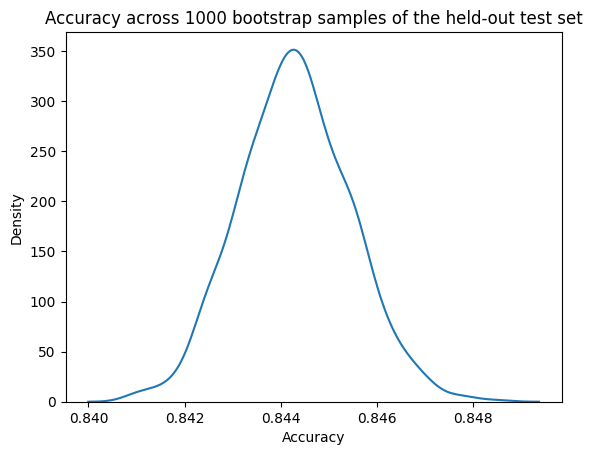

In [ ]:
sns.kdeplot(accuracy)
plt.title("Accuracy across 1000 bootstrap samples of the held-out test set")
plt.xlabel("Accuracy")
plt.show()

In [ ]:
median = np.percentile(accuracy, 50)
alpha = 100-95
lower_ci = np.percentile(accuracy, alpha/2)
upper_ci = np.percentile(accuracy, 100-alpha/2)
print(
      f"Median accuracy is {median:.4f} with a 95% a confidence "
      f"interval of [{lower_ci:.4f},{upper_ci:.4f}].")

Median accuracy is 0.8443 with a 95% a confidence interval of [0.8421,0.8466].


# Comparsion of models

## Results and Comparision

We have used Random forest, decision tree, logistic regression, bootstrapping, gradient boost, XGboost andd k-NN models for this dataset.\
I am using recall precision and accuracy as a metric to compare the model as they seem to be very intutive and easy to interpret the quality of the model.

| Model              | Accuracy (%) | Precision | Recall    |
|---------------------|--------------|-----------|-----------|
| Dummy               | 65.87        | 51        | 51        |
| XGBoost             | 86.19        | 82        | 76        |
| Random Forest       | 86.01        | 82        | 74        |
| KNN                 | 84.12        | 78        | 72        |
| Decision Tree       | 79.15        | 70        | 70        |
| Gradient Boost      | 85.27        | 81        | 73        |
| Logistic Regression | 84.52        | 79        | 72        |

## Evaluation Metrics Overview

### Accuracy

Accuracy is a measure of the overall correctness of a model. It is calculated as the ratio of correctly predicted instances to the total instances. Mathematically, it can be expressed as:

Accuracy=\frac{True Positives + True Negatives}{Total Predictions}
### Precision

Precision is the ratio of correctly predicted positive observations to the total predicted positives. It focuses on the accuracy of positive predictions. Precision is defined as:

\[ Precision = \frac{True Positives}{True Positives + False Positives} \]

### Recall (Sensitivity or True Positive Rate)

Recall is the ratio of correctly predicted positive observations to the all observations in the actual positive class. It focuses on the model's ability to capture all relevant instances. Recall is expressed as:

\[ Recall = \frac{True Positives}{True Positives + False Negatives} \]



Since recall is where the value is lowest, we will rate them on the basis of recall. The best model in this is **XGBoost**, and it also seems to have the best precision.

Also, let us try to see the feature importance treand for this model

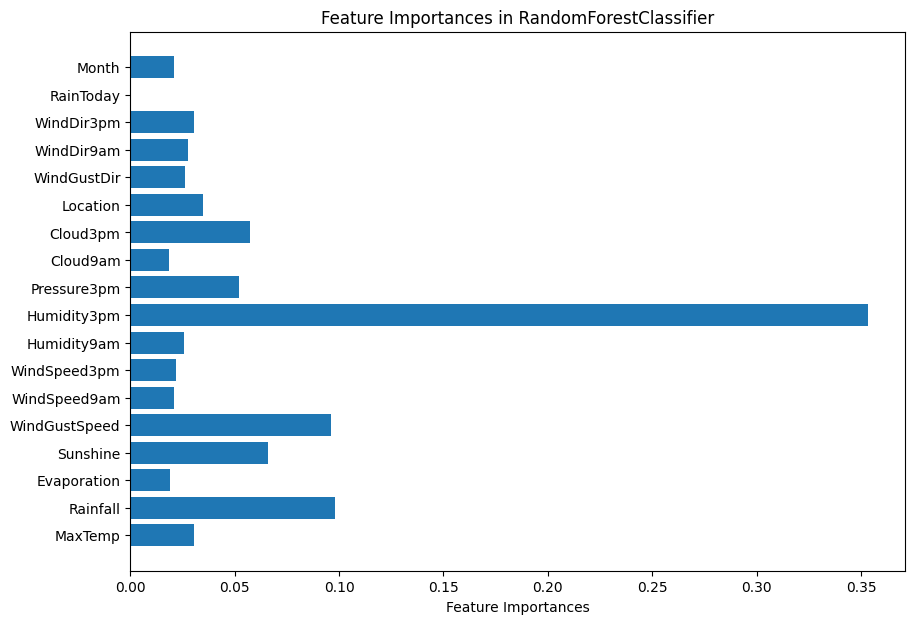

In [ ]:
feature_names = xgb.feature_names_in_
feature_importances = xgb.feature_importances_
f, ax = plt.subplots(figsize=(10, 7))
ax.barh(range(len(feature_importances)), feature_importances)
ax.set_yticks(range(len(feature_importances)))
ax.set_yticklabels(feature_names)
ax.set_title("Feature Importances in RandomForestClassifier")
ax.set_xlabel("Feature Importances")
plt.show()

It can be seen that humidity at 3 pm is one of the most import feature in determining whether it rains tomorrow or not, with rainfall and wind gust speed the other 2 most important factors, which seem logical, as these 3 have a good effect on rain.\
One might wonder if humidity 7pm would have been there, how accurate can the model get.


## Data processing

For EDA, i have -
1. Deleted duplicated values
2. Used label Encoder, as it is justified. For example, the directions can be seen as north, north north east, etc can be directly assigned integral values in a sequence, month can be given numbers from 1 to 12, so that months around june to august gets higher rain probability, etc
3. Used mode imputer for the missing object type values and mean imputer for numerical values
4. Removed the correlated features.
5. Handled outliers by thier corresponding confidence interval limits.